# Q1 Report
### Author: Jonathan Tanoto (A15418595)
### Mentor: Jingbo Shang (DSC 180A A02)
### December 5, 2021

### Introduction
AutoPhrase is an algorithm that extracts high-quality phrases from a given corpus of text. The idea behind it is to extract quality phrases, unlike n-grams, which can improve computational models for the applications of the algorithm. Most, if not almost all, methods to extract high quality phrases would rely on human experts with knowledge of the quality of the phrases for it to work. The novelty of AutoPhrase is that it does not need these experts needed for other methods. This sets AutoPhrase apart from other tagging methods as it is domain-independent with minimal human effort. AutoPhrase leverages Robust Positive-Only Training and POS-guided Phrasal Segmentation to be able to achieve the level of independence it has.

### Methods
**Robust Positive-Only Training**: High quality phrases are available in public knowledge bases like Wikipedia. This is leveraged in distance training to get rid of manual labeling effort. The algorithm independently builds samples of positive labels from the general knowledge bases and negative labels from the given domain corpora, and then train on that to produce some base classifiers.

**POS-Guided Phrasal Segmentation**: There exists a trade-off between accuracy and domain- independence when the phrase mining method is a product of some linguistic modeling. On one hand, limited linguistic knowledge decreases accuracy. On the other, heavily linguistic- trained models will make it less domain-independent. Therefore, a pre-trained part-of- speech (POS) tagger is implemented to enhance the performance of the algorithm. This will allow the method to better understand the boundary of phrases more accurately.

### What is a quality phrase?
“A phrase is defined as a sequence of words that appear consecutively in the text, forming a complete semantic unit in a certain context of a given document” (Shang). The quality of a phrase is defined to be the probability of the word sequence being a complete semantic unit, with the following criteria:

- Popularity: Quality phrases should occur with sufficient frequency in the given document collection.
- Concordance: The collocation of tokens in quality phrases occurs with significantly higher probability than expected due to chance
- Informativeness: A phrase is informative if it is indicative of a specific topic or concept.
- Completeness: Long frequent phrases and their sub-sequences within those phrases may both satisfy the 3 criteria above. A phrase is deemed complete when it can be interpreted as a complete semantic unit in some given document context.

AutoPhrase estimates the quality of the phrase based on the positive and negative pools twice, before and after the POS-guided phrasal segmentation.


### Metric
The first phase establishes a set of phrase candidates that contains all n-grams in the corpus given the threshold. Given a phrase candidate $w_1 w_2 ... w_n ,$ the phrase quality is:
$$Q(w_1 w_2 ... w_n) = P(⌈w_1 w_2 ... w_n⌋|w_1 w_2 ... w_n) ∈ [0,1] ,$$ where $Q\approx0$ means low-quality phrase, and $Q\approx1$ shows a high-quality phrase.

## Goals
1. Try to randomly pick 100 multi-word phrases whose scores are greater than 0.5. Manually check them and see what's the percentage of high-quality phrases.
2. Since these 100 multi-word phrases can be ranked by their scores, please plot a precision-recall curve too.
3. Try to run the word2vec code on the phrasal segmentation results to obtain phrase embedding. 
4. Pick 3 high-quality phrases from your previous annotations in step 1, run a similarity search among all multi-word phrases whose scores are greater than 0.5, and report the top-5 results. Comment on the results. 

### Extracting Multi-word phrases along with their scores 

In [33]:
# make sure run.py is executed with "python run.py" in order to populate /models
# for this assignment, to keep version control, run.py was not run in this directory
# "models_final" is duplicate "models" folder run on dsmlp that will be used instead for analysis
import os

models_path = "../models_final/DBLP/AutoPhrase_multi-words.txt"
multi_phrases = []
with open(models_path, "r") as f:
    for line in f:
        arr = line.split('\t')
        arr[0] = float(arr[0])
        arr[1] = str(arr[1][:-1])
        multi_phrases.append(tuple(arr))

In [129]:
multi_phrases[:10]

[(0.9864838157, 'money laundering'),
 (0.9853626171, 'sleep apnea'),
 (0.9848519374, 'blast furnace'),
 (0.9848116912, 'orthopedic surgery'),
 (0.9839320615, 'doctoral consortium'),
 (0.9837732296, 'bitonic sort'),
 (0.9835874403, 'sleep deprivation'),
 (0.9833576899, 'nested dissection'),
 (0.9833394379, 'magnetic levitation'),
 (0.9833320615, 'josephson junctions')]

### Random pick 100 multi-word phrases with score greater than 5

In [55]:
import random

random.seed(11)

# find index where phrase has score lower than 0.5
cutoff = 0
for i in multi_phrases:
    if i[0] < 0.5:
        break
    cutoff += 1

# sample 100 random indices    
ind = sorted(random.sample(range(cutoff), 100))

# append in array
hundred = []
for i in ind:
    hundred.append(multi_phrases[i])

In [130]:
hundred[:10]

[(0.9776772996, 'presidential election'),
 (0.9696707174, 'advance reservation'),
 (0.9576116248, 'bird species'),
 (0.9574645526, 'eng syst saf'),
 (0.9555348761, 'power plant'),
 (0.9432152047, 'meeting room'),
 (0.9429247613, 'user interface'),
 (0.9379547803, 'mesh refinement'),
 (0.9327036243, 'channel state information'),
 (0.924076646, 'sony ericsson')]

Out of the list of multi-word phrases above, we have identified 7 non-high quality phrases.
1. eng syst saf
2. harnessing collective intelligence
3. batch means
4. practicing software engineers
5. imbedded markov chain
6. ip over wdm networks
7. 65 nm

This results in 93% of the phrases above being high quality.

### Precision-Recall Graph

The evaluation metrics that we will use is the precision-recall curve. For a list of extracted phrases, precision is the number of true quality phrases divided by the number of predicted quality phrases; recall is the number of true quality phrases divided by the total number of quality phrases.

$$Precision = \frac{Correct}{Count}$$

$$Recall = \frac{Correct}{(TotalNumberOfQualityPhrases)}$$

In [60]:
bad_phrases = ["eng syst saf",
               "harnessing collective intelligence",
               "batch means",
               "practicing software engineers",
               "imbedded markov chain",
               "ip over wdm networks",
               "65 nm"]

In [88]:
precision_recall = []
count = 0
correct = 0

for phrase in hundred:
    count += 1
    if phrase[1] in bad_phrases: 
        continue
    # hundred only consists of Positive labels
    # Precision = TP / (TP + FP) = Correct / Count
    # Recall = TP / (TP + FN) = Correct / (100-7)
    correct += 1
    precision = correct / count
    recall = correct / (len(hundred) - len(bad_phrases))
    precision_recall.append(tuple([precision, recall]))

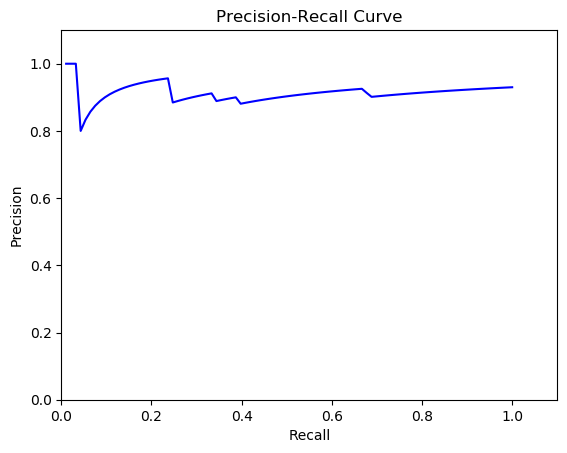

In [89]:
import matplotlib.pyplot as plt

precision = [elem[0] for elem in precision_recall]
recall = [elem[1] for elem in precision_recall]

fig, ax = plt.subplots()
ax.plot(recall, precision, color='blue')

# add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

# set axis limits
plt.axis([0, 1.1, 0, 1.1])

# display plot
plt.show()

### Running word2vec Code on the Phrasal Segmentation Results

The code below will parse through segmentation.txt and join high-quality phrases with an underscore. For example, it will convert "... {phrase}support vector machine{/phrase} ..." to "... support_vector_machine ..." in order to preserve the phrasal segmentation before turning the words into vector form.

In [124]:
# load phrasal segmentation results
import os
import re

models_path = "../models_final/DBLP/segmentation.txt"
seg = []
with open(models_path, "r") as f:
    count = 0
    for line in f:
        if count%2 == 1:
            count += 1
            continue
        r = re.sub(r'<phrase_Q.......', '<phrase>', line)
        s = re.sub(r"<phrase>(.*?)<\/phrase>", lambda g: f'{g.group(1).replace(" ", "_")}', r)
        seg.append(s[:-2])
        count += 1

In [126]:
sentences = [s.split() for s in seg]

In [128]:
from gensim.models import Word2Vec

# train model
model = Word2Vec(sentences)

### Similarity Search

For this section, we will be picking 3 high-quality phrases from multi-word phrases in the first section and run a similarity search among all multi-word phrases whose scores are greater than 0.5. We will report the top 5 results.
1. money_laundering
2. estrogen_receptor
3. database_systems

In [149]:
mult_high = ['_'.join(p[1].split()) for p in multi_phrases if p[0]>.5]

In [173]:
candidates = ['money_laundering', 'estrogen_receptor', 'database_systems']
for c in candidates:
    print("Most similar phrases to: "+ c)
    sim_arr = []
    for p in mult_high:
        try:
            sim_arr.append([p, model.wv.similarity(c, p)])
        except KeyError: 
            continue
    sim_arr.sort(key=lambda x: x[1], reverse=True)
    for p in sim_arr[1:6]: # ignore first since it will be the same phrase 
        print(p)
    print("-------------------------------------------------")

Most similar phrases to: money_laundering
['credit_card_fraud', 0.77307796]
['adverse_drug_events', 0.77107453]
['sybil_attacks', 0.7433408]
['driver_inattention', 0.74244493]
['financial_fraud', 0.74137884]
-------------------------------------------------
Most similar phrases to: estrogen_receptor
['reverse_transcriptase', 0.8015097]
['binding_pocket', 0.78709424]
['somatic_mutations', 0.7838313]
['ribosomal_protein', 0.77083826]
['biological_features', 0.7703784]
-------------------------------------------------
Most similar phrases to: database_systems
['database_management_systems', 0.86014616]
['storage_systems', 0.79723114]
['file_systems', 0.7957947]
['distributed_systems', 0.72226775]
['computer_systems', 0.7018486]
-------------------------------------------------


Looking at the results above, it seems like the phrase embedding worked well on the word2vec. We can see from the output above that the five top similar phrases for each phrase seems to be related and similar to one another.